In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
import sympy as sp

### This script integrates the model Eqs.14 of the main text with a discrete delay kernel, corresponding to Fig. 5C, Fig. 6, and Fig. 7. The script makes the integration of both mechanisms (RM and SM). In the case below, we use the set of parameters of Fig. 5C. Other figures of the paper can be obtained by changing the parameter values. Please note that other system parameter values can need a fine-tuning of integration parameters, like the time step or atol.

In [7]:
# Define the DDE function
def eqs_dde_rhs(kon, kof, alpha, gamma):
    gm, gp = gamma
    equation = [
        -kon[0]*y(0,t)*y(3,t -gp) +kof[0]*y(1,t),
        -kon[1]*y(1,t)*y(3,t -gp) +kof[1]*y(2,t) +kon[0]*y(0,t)*y(3,t -gp) -kof[0]*y(1,t),
        -kon[2]*y(2,t)*y(3,t -gp) +kof[2]*(1. -y(0,t) -y(1,t) -y(2,t)) +kon[1]*y(1,t)*y(3,t -gp) -kof[1]*y(2,t),
        (alpha[0]*alpha[1]/gp)*y(0,t) -gm*y(3,t)
    ]
    return equation

#Setting parameters values
p = 0.246
q = 30.0
e = 10.0
alpha = [33.0, 4.5]
gamma = [0.23, 4.6]

# define integrator for RM and its parameters
konR = [3 * p, 2 * p * e, p * e * e]
kofR = [q, 2 * q, 3 * q]
ddesysRM = jitcdde(eqs_dde_rhs(konR, kofR, alpha, gamma), verbose=False)
ddesysRM.initial_discontinuities_handled = True
ddesysRM.set_integration_parameters(atol=1e-8, rtol=1e-5, min_step=1e-12)

# define integrator for SM and its parameters
konS = [3 * p, 2 * p, p]
kofS = [q, 2 * q / e, 3 * q / (e * e)]
ddesysSM = jitcdde(eqs_dde_rhs(konS, kofS, alpha, gamma), verbose=False)
ddesysSM.initial_discontinuities_handled = True
ddesysSM.set_integration_parameters(atol=1e-8, rtol=1e-5, min_step=1e-12)

#Initial condition
ti = 0  #initial time
ddesysRM.constant_past([1.0, 0.0, 0.0, 0.0]) #constant values for t<ti
ddesysSM.constant_past([1.0, 0.0, 0.0, 0.0]) #constant values for t<ti

tf = 300 #ending time
n_points = 100000 # Number of points to use in plots
ts = np.linspace(ti, tf, n_points)

#solving!!!
yRM = [ddesysRM.integrate(t) for t in ts]
ySM = [ddesysSM.integrate(t) for t in ts]

yRM = np.array(yRM)
ySM = np.array(ySM)

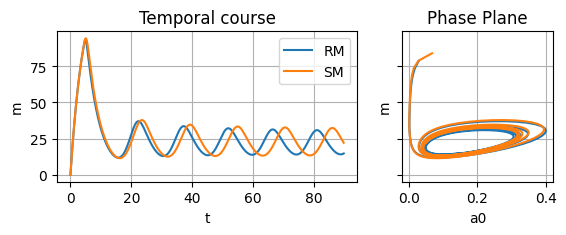

In [8]:
#Plotting
figure, axis = plt.subplots(1,2,sharex="col", sharey="row", gridspec_kw=dict(width_ratios=[2, 1])) 
axis[0].plot(ts[:30000:100], yRM[:30000:100,3],label='RM')
axis[0].plot(ts[:30000:100], ySM[:30000:100,3],label='SM')
axis[0].set_title("Temporal course")  
axis[0].set_xlabel('t')
axis[0].set_ylabel('m')
axis[1].plot(yRM[2000:30000:100,0], yRM[2000:30000:100,3],label='RM')
axis[1].plot(ySM[2000:30000:100,0], ySM[2000:30000:100,3],label='SM')
axis[1].set_title("Phase Plane") 
axis[1].set_xlabel('a0')
axis[1].set_ylabel('m')
axis[0].set_box_aspect(1/2)
axis[0].legend(loc='upper right')
axis[1].set_box_aspect(1)
axis[0].grid()
axis[1].grid()
plt.show() 